In [1]:
import model_funcs
import sympy as sm

# Our Model

Our model is the classic solowmodel, but instead of having a fixed savings rate, in each period the savings rate is decided by a micro-household optimization problem 

**Micro-foundation of the savingsrate** 

Representative household utilityfunction in single periode:
$$
u\left(c_{t}\right)=\frac{c^{1-\theta}-1}{1-\theta}
$$
When the household sums its total utility for mulitple future periods, it disocunts future consumption for immediate consumption by $1-\beta$ so utility for all periods from period 0 to period T, given a vector C of consumption in each period is:
$$
U\left(C\right)=\sum_{t=0}^{T}\beta^{t}\frac{c_{t}^{1-\theta}-1}{1-\theta}
$$
We assume that the household understands how the solow model works, e.g. how production for consumption is made and how capital accumulation works.
$$
Y_{t}=AK_{t}^{\alpha}L_{t}^{1-\alpha} 
\Rightarrow c_{t}\cdot L_{t} = \left(1-s_{K_t}\right)\cdot AK_{t}^{\alpha}L_{t}^{1-\alpha} 
$$ $$
K_{t+1}=s_{Kt}\cdot Y_{t}+\left(1+\delta\right)K_{t}
$$
$$
L_{t+1}=\left(1+n\right)L_{t}\
$$
Rewriting to per capita terms we get:
$$
y_{t}=A k_{t}^{\alpha} \Rightarrow
c_{t} = \left(1-s_{Kt}\right) A k_{t}^{\alpha}
$$ $$
k_{t+1}= \frac{1}{1+n} \left(s_{Kt}\cdot A k_{t}^{\alpha} + \left(1+\delta\right)k_{t} \right)
$$
This is our 'budget constraint' more precisely defined as production constraints for all periods 

So the final optimizationproblem is:
$$
\max_{s_{K_t}}U\left(C\right)=\sum_{t=0}^{T}\beta^{t}\frac{c_{t}^{1-\theta}-1}{1-\theta}
$$
$$ s.t.$$$$
c_{t} = \left(1-s_{Kt}\right) A k_{t}^{\alpha},\;t\in [0,T]
$$$$
k_{t}=
\begin{cases}
k_{0}& \text{if }t=0\\
\frac{1}{1+n} \left(s_{Kt-1}\cdot A k_{t-1}^{\alpha} + \left(1+\delta\right)k_{t-1} \right)& \text{if }t\in\left[1,T\right]
\end{cases}
$$$$
k_{0} \text{ given}
$$
It's important to note that although the optimizationsolution, $s_{Kt}$, is solved for all periods. Only the solution for t=0 is used, since the problem is solved again in the next period. E.g. in each period the household formualtes a plan for current and future comsumption. In the current period the plan is pursued but in the following period a new plan is formulated, which is then also only followed for one period. 

**Macro foundations**

We use the basic solow model but with an adjustable savingsrate for each period. Rewritten we got the following capital-accumulation pr. capita:

$$
k_{t+1}= \frac{1}{1+n} \left(s_{Kt}\cdot A k_{t}^{\alpha} + \left(1+\delta\right)k_{t} \right)
$$$$
y_{t}=A k_{t}^{\alpha}
$$
For a fixed savings rate we know that this model has convergenge to steady state. With the adjustable micro-foundated savingsrate we do not yet know if we have convergens, but we do not that convergence will imply, $k_{t+1}=k_{t}=k^{*}$ thus we have:
$$
k^{*}= \frac{1}{1+n} \left(s_{Kt}\cdot A {k^{*}}^{\alpha} + \left(1+\delta\right)k^{*} \right)
$$
And can use sympy to derive that if we have a convergence to steady savingsrate our steady state capital for a given savings will be:

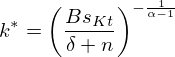

In [2]:
sm.init_printing(use_unicode=True)
ss_k,find_ssk_sk = model_funcs.steadystate()
ss_k

In [3]:
sm.init_printing(use_unicode=False)

# Solving the micro-foundation numerically

We set up parameter values: 

$\theta$, determining the representative household's aversion to fluctations in consumption is set to 0.5 <br>
$\beta$, determining how much the representative households values immediate above future consumption, is set to 0.99. Representing a low preference. <br>
$\alpha$, with a Cobb-Douglas production function the incomeshare of capital, is set to $\frac{1}{3}$, a ordinary macro-assumption. <br>
$\delta$, capital depreciation, is set to 0.05. <br>
$n$, population growth is set to 0.008 representing average european population growth. <br>
$B$ and $L_{0}$ is normalized to 1, initial capital. <br>
$K_{0}$ is set to below the steady state. <br>
$t$, the amount of future time periods considered by the household, is set to 40 for two reasons: <br>
1. Computational limitations, honestely speed becomes a factor when we simulate a more foresighted representative household.
2. It approximately represents the average remaining lifetime of the working population. As we asumme no 'warm glow' from bequesting, this will also be the timeline that the population cares about on average. 


In [4]:
# Parameters
#Micro:
theta = 0.5
beta = 0.99
#Macro:
alpha = 1/3
delta = 0.05
n = 0.008

# production:
b = 1
k0 = 5
l0 = 1


t = 40

# time preference utility weights and population growth 
# are precomputed to save time:
weight = np.array([beta**i for i in range(t)])
l = np.array([l0*(1+n)**i for i in range(t)])

First we look at how, for differnt thetas, optimal savings rate in period t=0, depends on the level of initial capital:

In [79]:
k_n = 50
thetas = [0.4,0.5,0.7]
sks = [np.zeros(k_n) for i in range(3)]
k0s = np.linspace(0.001,30,k_n)

for j in range(3):
    for i in range(k_n):
            sks[j][i] = model_funcs.optimal_sks(
                t, b, l, weight, delta, alpha, thetas[j], k0s[i])

    

In [6]:
import matplotlib.pyplot as plt

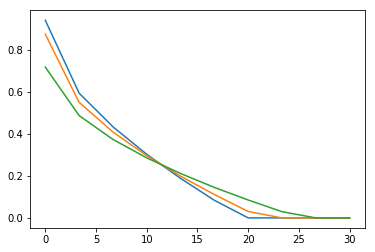

In [60]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(k0s,sks[0])
ax.plot(k0s,sks[1])
ax.plot(k0s,sks[2])

In [8]:
from bokeh.io import output_notebook, push_notebook,show
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter

In [66]:
def plotting(x,ys, x_array, y_arrays,title = 'Figure'):
    
    hover = HoverTool(tooltips= [(f'{x}','@x{0,0.0}'),
        (f'{y}','@y{0,0.0}')])
    
    tools="pan,box_zoom,reset,save"
    data = {'x': x_array, 'y': y_array}
    source = ColumnDataSource(data)
    
    p = figure(title=f'{title}',tools=[hover,tools], 
               x_axis_label=f'{x}', y_axis_label=f'{y}')
    
    p.line(x='x', y='y', source=source, 
           legend= f'{x}')
    
    p.legend.location = "top_center"
    
    show(p,notebook_handle=True)
    

In [80]:
hover = HoverTool(tooltips= [('capital','@x{0,0.0}'),
        ('savings','@y{0,0.0}')])
tools="pan,box_zoom,reset,save"
data = {'x': k0s, 'y': sks[0]}
source = ColumnDataSource(data)
    
p = figure(title='Figure 1',tools=[hover,tools], 
               x_axis_label=f'Capital', y_axis_label=f'Savings rate')
    
p.line(x='x', y='y', source=source, color = 'blue', 
           legend= 'Theta')
    
p.legend.location = "top_center"


In [81]:
show(p,notebook_handle=True)

In [67]:
plotting("Capital", "Savings", k0s, sks[0])

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: y [renderer: GlyphRenderer(id='1378', ...)]
